### Author: Cao Siliang, Feng Ling, Michael Lees and Debraj Roy

---
The MIT License (MIT)

Copyright (c) 2024 Cao Siliang

Based on previous versions written by
Feng Ling, Michael Lees, Debraj Roy

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---

## Background
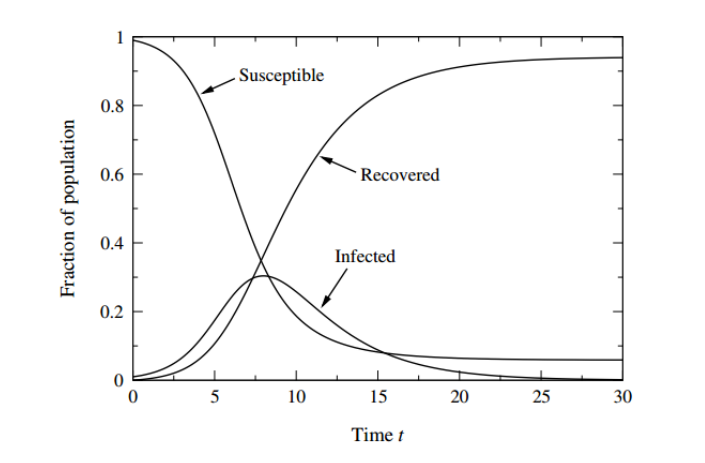

<div align="center">
Image source: Newman, Mark, Networks, 2nd edn (Oxford, 2018; online edn, Oxford Academic, 18 Oct. 2018), https://doi.org/10.1093/oso/9780198805090.001.0001, Page 615
</div>

The SIR model is a simple model used to describe the spread of disease. As shown above, this model divides the population into three categories:
- Susceptible (S): Healthy people who have not yet been infected by the virus and cannot infect others.
- Infected (I): People who are infected by the disease have, at the same time, the ability to infect others.
- Removed (R): People who were once infected with the disease have now recovered and no longer have the ability to transmit it and will no longer be infected with the virus.

The size of each group follows the following equations:

\begin{equation}
\frac{ds}{dt} = -\beta si\\
\end{equation}
\begin{equation}
\frac{di}{dt} = \beta si - \gamma i\\
\end{equation}
\begin{equation}
\frac{dr}{dt} = \gamma i
\end{equation}

where:

- $\beta$ is the probability that an infected node spreads the information to each of its susceptible neighbors in each time step.

- $\gamma$ is the probability that an infected node recovers in each simulation time step. 

- $\phi=\beta/\gamma$ is characterizing the spreading strength of the message.

This model can also be used to describe the propagation of viral information in social networks. In the context of social networks like Twitter,
- Susceptible (S): This represents individuals who have yet to share a specific tweet. They have been exposed to the tweet but haven't retweeted it, much like someone who has been exposed to a disease but hasn't contracted it.
- Infected (I): In our context, 'infected' refers to individuals who have retweeted the tweet, and it is currently visible to their followers. The 'infection' spreads as followers see and potentially retweet the message.
- Removed (R): These individuals have retweeted the tweet before, but it has since been removed or hidden from their followers' view, similar to a person no longer being contagious.



## The problem
The goal of this PROJECT is to explore how to select a group node to monitor so as to maximise the amount of VIRAL information received.


## The code
    


In [44]:
import random # for random choice function
import networkx as nx #import NetworkX
import numpy as np #import numpy
import matplotlib.pyplot as plt #import matplotlib for plotting/drawing grpahs
import random # for random choice function
import operator #standard python library used for sorting
import sys
from enum import Enum
from tqdm import tqdm
import time
import operator
import concurrent.futures
from collections import Counter

class State(Enum):
    Succeptible = 0
    Infected = 1
    Removed = 2
    
def reset(G):
    """ 
    :param G: The graph to reset
    
    Initialise/reset all the nodes in the network to be succeptible. 
    Used to initialise the network at the start of an experiment
    
    This reset function is used before the loop, for the sake of initialization
    """
    nx.set_node_attributes(G, State.Succeptible, 'state')
    
def reset_with_removed_set(G, removed_set):
    """ 
    :param G: The graph to reset
    :param removed_set: list saving the nodes to reset
    
    This function is used inside the loop, only reset the nodes infected in one run
    Significantly reduces computation time 
    
    """
    {G.nodes[node].update({'state': State.Succeptible}) for node in removed_set}

        
def initialise_infection_random(G, all_nodes, num_to_infect):
    """
    :param G: Graph to infect nodes on
    :param num_to_infect: Number of nodes to infect on G
    
    Set the state of a random selection of nodes to be infected. 
    numToInfect specifices how many infections to make, the nodes 
    are chosen randomly from all nodes in the network
    
    G should be be converted to list, when apply this function to directed network
    
    """
    nodes_to_infect = random.sample(all_nodes, num_to_infect)
    nx.set_node_attributes(G, {n: State.Infected for n in nodes_to_infect}, 'state')
    return nodes_to_infect



def transmission_model_factory(beta=0.03, gamma=0.05):
    """
    :param beta: specifies the rate of infection (movement from S to I)
    :param gamma: specifies the rate of recover/removal (movement from I to R)
    :returns: a function specifying infection model.
    
    Creates and returns an instance of a infection model. This allows us 
    to create a number of models with different beta and gamma parameters.
    Note that in a single time step an infected node can infect their neighbours
    and then be removed.
    
    The updated function do not check every nodes in each time steps.
    It only check the nodes and their neighbors based on the input"infected_set"
    
    """
    def m(infected_set, G):
        
        new_infected = set()
        new_removed = set()
        
        for n in infected_set:
            if G.nodes[n]['state'] == State.Infected:
                # This line is adjusted for directed network
                susceptible_neighbors = [k for k in G.neighbors(n) if G.has_edge(n, k) and G.nodes[k]['state'] == State.Succeptible]
                for k in susceptible_neighbors:
                    rand_beta = random.random()
                    if rand_beta <= beta:
                        G.nodes[k]['state'] = State.Infected
                        new_infected.add(k)
                
                rand_gamma = random.random()
                if rand_gamma <= gamma:
                    G.nodes[n]['state'] = State.Removed
                    new_removed.add(n)

        return new_infected, new_removed

    return m

def execute_one_step_optimized(G, infected_set, model):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G
    :infected_set: set saving the information of infected nodes
    :returns: new_infected, new_removed for run_spread_simulation function to update infected_set

    executes the infection model on all nodes in G
    """
    new_infected, new_removed = model(infected_set, G)
    return new_infected, new_removed

def run_spread_simulation_test(G, model, initially_infected):
    """
    :param G: the Graph on which to execute the infection model
    :param model: model used to infect nodes on G
    :param initial_infection_count: Number of nodes to infect on G
    :returns : a 5-tuple containing, list of S,I,R nodes at end, the end time 
               and the list of initially infected nodes (useful for visulisation)
               and set of removed_list 

    Runs a single simulation of infection on the graph G, using the specified model. 
    An initial infection count is specified to infect a set of nodes. 
    The simulation is executed until there are no more infected nodes, that is the 
    infection dies out, or everyone ends up removed.
    """
    i_results = []
    s_results = []
    r_results = []
    dt = 0

    # initializing the set
    infected = set(initially_infected)
    removed = set()

    while infected:
        # excute one step, and get new_infected and new_removed
        new_infected, new_removed = execute_one_step_optimized(G, infected, model)
          
        # updating the set based on the result
        infected.update(new_infected)
        infected -= new_removed
        removed.update(new_removed)
        
        # update the information 
        dt += 1
        i_results.append(len(infected))
        r_results.append(len(removed))
        s_results.append(len(G)-len(infected)-len(removed))

    return s_results, i_results, r_results, dt, initially_infected,removed


def plot_infection(S, I, R, G):
    peak_incidence = max(I)
    peak_time = I.index(max(I))
    total_infected = S[0] - S[-1]

    plt.plot(range(len(S)), S, color='g', linestyle='-', label="S")
    plt.plot(range(len(I)), I, color='b', linestyle='-', label="I")
    plt.plot(range(len(R)), R, color='r', linestyle='-', label="R")
    plt.axhline(peak_incidence, color='b', linestyle='--', label="Peak Indidence")
    plt.annotate(str(peak_incidence), xy=(1, peak_incidence + 10), color='b')
    plt.axvline(peak_time, color='b', linestyle=':', label="Peak Time")
    plt.annotate(str(peak_time), xy=(peak_time + 1, 8), color='b')
    plt.axhline(total_infected, color='r', linestyle='--', label="Total Infected")
    plt.annotate(str(total_infected), xy=(1, total_infected + 10), color='r')
    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('Count')
    plt.title('SIR for network size ' + str(G.order()))
    plt.show()

# Draw network function is unchanged
def plotDistribution(_influences,nbin=50):
    plt.hist(_influences,range=[0,1],bins=nbin)
    plt.title(f"Realisations with bin = {nbin}")
    plt.xlabel("Number of infected nodes / Total number of nodes")
    plt.ylabel("Frequency")
    plt.show()

def initialise_infection_degree(G, num_to_infect, largest=True):
    degrees = G.degree()
    nodes_sorted_by_degree = sorted(degrees, key=operator.itemgetter(1), reverse=largest) 
    nodes_to_infect = [node[0] for node in nodes_sorted_by_degree[:num_to_infect]]
    for n in nodes_to_infect:
        G.nodes[n]['state'] = State.Infected
    return nodes_to_infect

def writing_simulation_log(times,starting_time,gap):
    
    file_name = f"{starting_time}_Diary_TEST_Optimazed_SIR.txt"
    time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    if times%gap ==0:
        with open(file_name, 'a') as f:
            f.writelines(f"The current dates are {time}, ") 
            f.writelines(f"The simulation has finished {times} runs\n") 
    

# Main process for information spreading simulation

In [52]:
#network_name = "singapore_reduced.gexf"
#graph = nx.read_gexf(network_name)
graph = nx.barabasi_albert_graph(1000, 5) 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.33it/s]


The expected influence of the seed nodes is 0.90908


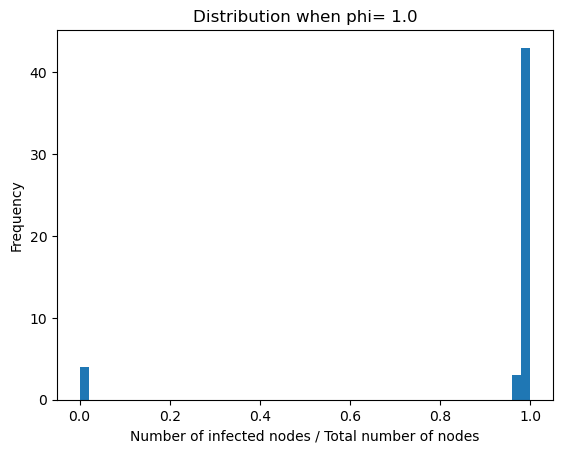

'\ncurrent_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")\nfile_name = f"{starting_time}_output_TEST_Optimazed_SIR.txt"\nsorted_items = sorted(my_dict.items(), key=lambda item: item[1], reverse=True)\noutput_content = [f"{key} {value}\n" for key, value in sorted_items]\n\nwith open(file_name, \'w\') as f:\n    f.writelines(f"The network in this simulation is singapore_reduced.gexf\n") \n    f.writelines(f"The total run is {sampleSize}\n") \n    f.writelines(f"The simulation end in {_+1} runs\n") \n    f.writelines(f"The Beta and Gamma of this simulation is {beta}，{gamma}\n") \n    f.writelines(output_content) \n\n'

In [53]:
from collections import defaultdict
import numpy as np
import datetime

"""
variable declaration

"""

beta = 0.050
gamma = 0.05
ini = 1  # Initially infected number of nodes
sampleSize = 50
m = transmission_model_factory(beta, gamma)  # Create our transmission model

starting_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

Influences = []  # Stores the total number of removed nodes in each run
removed_set = {}  # save the index of removed nodes for each runs
my_dict = defaultdict(int)  # Using defaultdict for automatic handling of new entries
reset(graph) # for state initialization at beggining

"""
Simulation Zone

"""


for _ in tqdm(range(sampleSize)):
    
    reset_with_removed_set(graph, removed_set)  
    initially_infected = initialise_infection_random(graph, all_nodes, ini)
    S, I, R, endtime, ii, removed_set= run_spread_simulation_test(graph, m, initially_infected)
    ratio = len(removed_set) / len(graph)
    writing_simulation_log(_,starting_time,gap=500)

    for node in removed_set:
        my_dict[node] += 1
    Influences.append(ratio)
    
print('The expected influence of the seed nodes is', np.average(Influences))


plt.hist(Influences,range=[0,1],bins=50)
plt.title(f"Distribution when phi= {beta/gamma}")
plt.xlabel("Number of infected nodes / Total number of nodes")
plt.ylabel("Frequency")
plt.show()



"""
Out put zone

"""

"""
current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
file_name = f"{starting_time}_output_TEST_Optimazed_SIR.txt"
sorted_items = sorted(my_dict.items(), key=lambda item: item[1], reverse=True)
output_content = [f"{key} {value}\n" for key, value in sorted_items]

with open(file_name, 'w') as f:
    f.writelines(f"The network in this simulation is singapore_reduced.gexf\n") 
    f.writelines(f"The total run is {sampleSize}\n") 
    f.writelines(f"The simulation end in {_+1} runs\n") 
    f.writelines(f"The Beta and Gamma of this simulation is {beta}，{gamma}\n") 
    f.writelines(output_content) 

"""



# Showcase of SIR model 

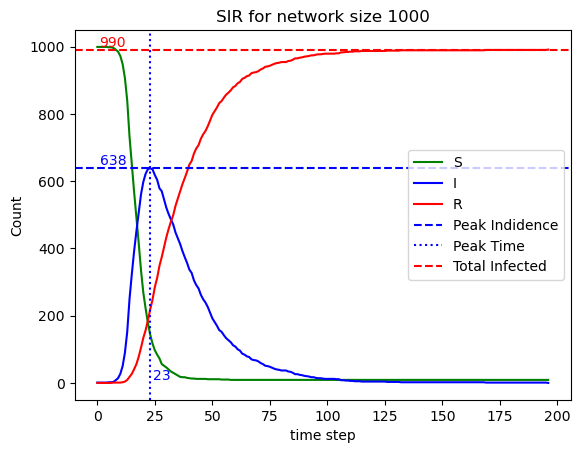

In [54]:
plot_infection(S,I,R,Gra)

## The bimodel behavior and the critical point

The physical reason behind this bimodal distribution is due to the existence of the so-called 'Giant Component' in the network. A 'Giant component' is the connected set of nodes through infection paths. Statistical mechanics analysis leads to the conclusion that the size (number of nodes) inside the giant component is unique when the size of the whole network is infinite. The peak on the right of the histogram has a position corresponding to the size of the giant component. Now it is clear why the position of that peak is around 0.2 regardless of the initialisation condition.

But there is a catch here. A message needs to go 'viral' to be considered as viral marketing. This 'viral' condition has a clear definition in complex networks, called critical threshold $\phi_c$, where $\phi$ characterizing the spreading strength of the message. We will see from the example of Erdos-Renyi network below.

## Below the critical threshold

The network has average degree 5, thus its critical threshold $\phi_c=0.2$.
The transmission model has $\beta=0.01$ and $\gamma=0.5$, thus a $\phi$ value smaller than the critical threshold, and we expect the spreading not be big.

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2735.40it/s]


The expected influence of the seed nodes is 0.00534


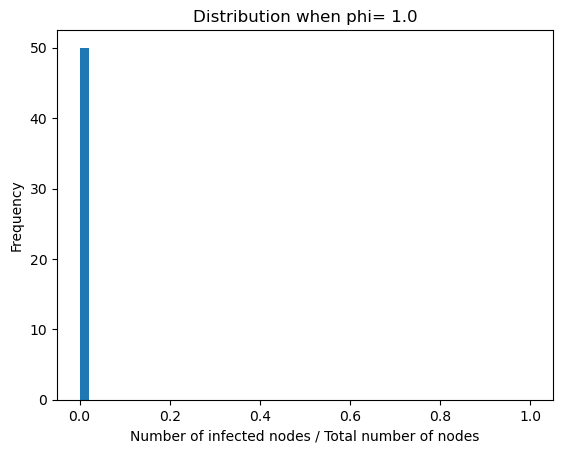

In [60]:
N = 1000 # size of network to make
graph = nx.erdos_renyi_graph(N,5.0/N) # create ER network with average degree 5.0
m = transmission_model_factory(0.01, 0.5) # create our transmission model
ini = 5 #initially infected number of nodes


all_nodes = list(graph.nodes())
starting_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

Influences = []  # Stores the total number of removed nodes in each run
removed_set = {}  # save the index of removed nodes for each runs
my_dict = defaultdict(int)  # Using defaultdict for automatic handling of new entries
reset(graph) # for state initialization at beggining

"""
Simulation Zone

"""


for _ in tqdm(range(sampleSize)):
    
    reset_with_removed_set(graph, removed_set)  
    initially_infected = initialise_infection_random(graph, all_nodes, ini)
    S, I, R, endtime, ii, removed_set= run_spread_simulation_test(graph, m, initially_infected)
    ratio = len(removed_set) / len(graph)
    writing_simulation_log(_,starting_time,gap=500)

    for node in removed_set:
        my_dict[node] += 1
    Influences.append(ratio)
    
print('The expected influence of the seed nodes is', np.average(Influences))


plt.hist(Influences,range=[0,1],bins=50)
plt.title(f"Distribution when phi= {beta/gamma}")
plt.xlabel("Number of infected nodes / Total number of nodes")
plt.ylabel("Frequency")
plt.show()


## Above the critical threshold

Now we change the transmission model parameter to $\beta=0.15$ and $\gamma=0.5$, such that the $\phi$ value is above the critical threshold. Here we would observe that some of the realisations reached a significant portion of the whole network.

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 195.32it/s]


The expected influence of the seed nodes is 0.3481


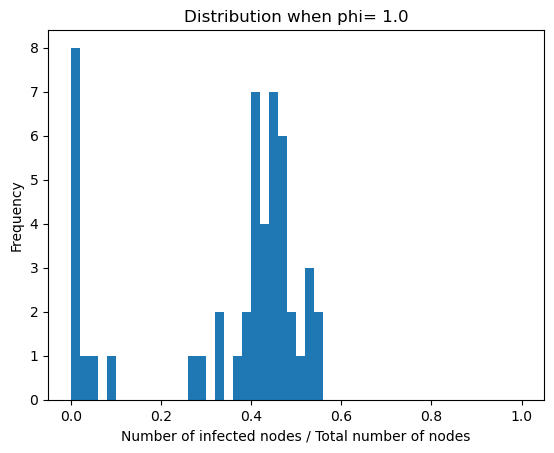

In [61]:
N = 1000 # size of network to make
graph = nx.erdos_renyi_graph(N,5.0/N) # create ER network with average degree 5.0
m = transmission_model_factory(0.15, 0.5) # create our transmission model
ini = 5 #initially infected number of nodes


all_nodes = list(graph.nodes())


starting_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

Influences = []  # Stores the total number of removed nodes in each run
removed_set = {}  # save the index of removed nodes for each runs
my_dict = defaultdict(int)  # Using defaultdict for automatic handling of new entries
reset(graph) # for state initialization at beggining

"""
Simulation Zone

"""


for _ in tqdm(range(sampleSize)):
    
    reset_with_removed_set(graph, removed_set)  
    initially_infected = initialise_infection_random(graph, all_nodes, ini)
    S, I, R, endtime, ii, removed_set= run_spread_simulation_test(graph, m, initially_infected)
    ratio = len(removed_set) / len(graph)
    writing_simulation_log(_,starting_time,gap=500)

    for node in removed_set:
        my_dict[node] += 1
    Influences.append(ratio)
    
print('The expected influence of the seed nodes is', np.average(Influences))


plt.hist(Influences,range=[0,1],bins=50)
plt.title(f"Distribution when phi= {beta/gamma}")
plt.xlabel("Number of infected nodes / Total number of nodes")
plt.ylabel("Frequency")
plt.show()
